In [2]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.linalg as lin
import scipy.special as spl
import scipy.integrate as inte

## Get physical constants from Scipy
import scipy.constants as con
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
k = con.physical_constants['Boltzmann constant in eV/K'][0]

In [3]:
## This needs to be in a seperate cell from the imports
## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 150,  # to adjust notebook inline plot size
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
#     'figure.figsize': [3.5, 2.625], # 4 x 3
#     'figure.figsize': [4, 3], # 4 x 3
    'figure.figsize': [4*1.125, 3*1.125], # 4x3, full slide in keynote
    'font.family': 'serif',
    'figure.max_open_warning':100
}
mpl.rcParams.update(params)


In [4]:
def position_operator(basis_size):
    """ Returns matrix representation of the position operator in the 
        basis of number states. Truncated at dimension 'basis size'. 
        """
    x = np.zeros((basis_size, basis_size))
    for n in range(basis_size-1):
        x[n, n+1] = 1/2**0.5 * np.sqrt(n+1)
        x[n+1, n] = 1/2**0.5 * np.sqrt(n+1)
    return x

In [5]:
def x_tothe_k(k, basis_size):
    x = position_operator(basis_size)
    return np.linalg.matrix_power(x, k)

In [6]:
def ham_g(basis_size, lambda_array):
    """ Returns matrix representation of (unitless) nuclear Hamiltonian 
        in the electronic ground state for the general anharmonic 
        oscillator truncated at dimension 'basis_size'. 
        
        The arg 'lambda_array' is expected to be 1D and contains the 
        scalar prefactors at each order of the polynomial potential 
        energy surface. The potential is therefore a polynomial of order 
        len(lambda_array) + 1.
        """
    H_prime = np.zeros((basis_size, basis_size)) 
    ## Define unperterbed harmonic hamiltonian 
    H_0 = np.diag(np.arange(0, basis_size))
    
    poly_order_plus_1 = len(lambda_array)
    for order in range(poly_order_plus_1):
        H_prime += lambda_array[order]*x_tothe_k(order, basis_size)
            
    H_g = H_0 + H_prime
#     H_g -= np.identity(basis_size)*lambda_array[0]
    return H_g

def displaced_ham_e(H_g, zp_energy, d):
    """ Returns matrix representation of (unitless) nuclear Hamiltonian 
        in the electronic ground state for the general anharmonic 
        oscillator truncated at dimension 'basis_size'. 
        
        The arg 'lambda_array' is expected to be 1D and contains the 
        scalar prefactors at each order of the polynomial potential 
        energy surface. The potential is therefore a polynomial of order 
        len(lambda_array) + 1.
        """ 
    basis_size = H_g.shape[0]
    a = np.zeros((basis_size, basis_size))
    for n in range(basis_size-1):
        a[n, n+1] = np.sqrt(n+1)
    displacement_op = lin.expm(d*a.T - d*a)
        
    H_e = (
        displacement_op @ H_g @ displacement_op.T
        + 
        zp_energy * np.identity(basis_size)
        )
    return H_e

In [7]:
def displaced_lambdas(
    lambda_array, 
    d, 
    include_H0_contri=True):
    """ Given the polynomial or order n = len('lambda_array')-1
            lambda_array[0]
            +
            lambda_array[1] * x
            + 
            lambda_array[2] * x**2
            ...
            + 
            lambda_array[-1] * x**n
        this function returns the coefficients upon introducing the 
        displacement 
            x -> x-d
        """
    n = len(lambda_array) - 1
    
    lambda_matrix = np.tri(n+1)
    lambda_matrix *= np.asarray(lambda_array)[:, None]
    
    ## For each term in the polynomial, we need to expand the binolial
    ## and resort coefficients into lambda array. 
    for m in range(0, n+1):
         for k in range(0, m):
            lambda_matrix[m, k] *= (
                spl.factorial(m)/(spl.factorial(k)*spl.factorial(m-k))
                )*(-d)**(m-k)
    new_lambdas = np.sum(lambda_matrix, axis=0)

    if include_H0_contri:
        ## Add contribution from displacing H_0
        new_lambdas[:2] += [d**2/2, -d]
    
    return new_lambdas

In [8]:
displaced_lambdas(
    [1, 2, 3 ,4], 
    0,) 

array([1., 2., 3., 4.])

In [9]:
def rho_e(H_e, T):
    if T is 0:
        return np.identity(H_e.shape[0])
    density_matrix_e = lin.expm(-H_e/(k*T))
    density_matrix_e /= np.trace(density_matrix_e)
    return density_matrix_e

In [10]:
def gap_fluc_op(basis_size, lambda_g_array, lambda_e_array, T):
    """ Returns energy gap fluctuation operator """
    density_matrix_e = rho_e(ham_g(basis_size, lambda_e_array), T=T) 
    
    delta = np.zeros((basis_size, basis_size))
    for n in range(len(lambda_e_array)):
        xk = x_tothe_k(n, basis_size)
        delta += (
            (lambda_g_array[n] - lambda_e_array[n])
            *
            (
                xk 
                - 
                np.identity(basis_size)
                *np.trace(xk@density_matrix_e)
                )
            )
    return delta

In [11]:
gap_fluc_op(4, [0,0,1], [1,0,2], T=0)

array([[ 8.5       ,  0.        , -0.70710678,  0.        ],
       [ 0.        ,  7.5       ,  0.        , -1.22474487],
       [-0.70710678,  0.        ,  6.5       ,  0.        ],
       [ 0.        , -1.22474487,  0.        ,  7.5       ]])

In [12]:
def a_matrix(H_e, Delta, order):
    miHe = -1j*H_e/hbar
    A = np.block([
        [miHe,             Delta,  ],
        [np.zeros_like(Delta), miHe,]
        ])
    for o in range(1, order-1):
        right_col = np.block([np.zeros_like(Delta)]*o + [Delta]).T
        bottom_row = np.block([np.zeros_like(Delta)]*(o+1) + [miHe])
    
        A = np.block([
            [A, right_col],
            [bottom_row]
            ])
    return A

In [13]:
def taylor_expm(A, n):
    e_A = np.identity(A.shape[-1], dtype='complex')
    if A.ndim is 3:
        e_A = e_A[None, ...]
    for i in range(1, n):
        e_A = e_A + (1/spl.factorial(i))*np.linalg.matrix_power(A, i)
    return e_A

In [14]:
def eigy_expm(A):
    vals,vects = np.linalg.eig(A)
    return np.einsum('...ik, ...k, ...kj ->...ij',
                     vects,np.exp(vals),np.linalg.inv(vects))
def loopy_expm(A):
    expmA = np.zeros_like(A)
    for n in range(A.shape[0]):
        expmA[n,...] = lin.expm(A[n,...])
    return expmA

def big_b_tilde(
    t, 
    order_n, 
    H_e, 
    rho_ex, 
    A=None,
    e_At=None,
    return_e_At_in_dict=False):
    
    """ Return shorthand B_n coefficient from Anda's paper 
            B_n = (i/hbar)^n * Tr{e^-iH_et [e^At]_[N-n, N] * rho_ex}
        """
#     print(f"Inside Bn, t = {t}")
    if type(t) is np.ndarray:
        H_e = H_e[None, ...]
        t = t[:, None, None]
        if A is not None:
            A = A[None, ...]
        exp_func = loopy_expm
#         exp_func = lambda a: taylor_expm(a, 100)
    else:
        exp_func = lin.expm
#     print(f"Shape of H_e inside B_n = {H_e.shape}")
#     print(f"Shape of A inside B_n = {A.shape}")
        
    ## First step compute matrix exponentials at time t
    e_iHet = exp_func(1j*H_e*t/hbar)
#     print(f"e_iHet = {e_iHet}")
    if A is not None:
        e_At = exp_func(A*t)
    
#     print(f"e_At = {e_At}")
    ## Navigate block array
    block_size = H_e.shape[-1]
    
    N = round(e_At.shape[-1]/block_size)
#     print(f" A block indexed from {(N-order_n-1)} to {N-order_n}")
    Bn_array = (
        (
            -1j
            /
            hbar
            )**order_n 
        *
        e_iHet
        @
        e_At[
            ...,
            (N-order_n-1)*block_size:(N-order_n)*block_size, 
            (N-1)*block_size:
            ]
        @
        rho_ex
        )
    Bn = np.trace(Bn_array, axis1=-2, axis2=-1)
    if return_e_At_in_dict:
        return {'B_n':Bn, 'e_At':e_At}
    return Bn

In [15]:
def flu_lineshape(
    omega, 
    gamma, 
    H_e,
    rho_ex,
    A,
    t_max=1000,
    t_points=100,
    return_integrand=False):
    """ Implement equation 31 from Anda """
    
    def integrand(_t):
        B_2_dict = big_b_tilde(
            _t, 
            order_n=2, 
            H_e=H_e, 
            rho_ex=rho_ex, 
            A=A,
            e_At=None,
            return_e_At_in_dict=True)
        B_2 = B_2_dict['B_n']
        e_At = B_2_dict['e_At']
#         print(f"e_At = {e_At}")
#         B_3 = big_b_tilde(
#             _t, 
#             order_n=3, 
#             H_e=H_e, 
#             rho_ex=rho_ex, 
# #             A = A,
#             e_At=e_At,
#             )
#         B_4 = big_b_tilde(
#             _t, 
#             order_n=4, 
#             H_e=H_e, 
#             rho_ex=rho_ex, 
#             e_At=e_At,)
#         B_5 = big_b_tilde(
#             _t, 
#             order_n=5, 
#             H_e=H_e, 
#             rho_ex=rho_ex, 
#             e_At=e_At,)
#         B_6 = big_b_tilde(
#             _t, 
#             order_n=6, 
#             H_e=H_e, 
#             rho_ex=rho_ex, 
#             e_At=e_At,)
#         print(f"B_2 = {B_2}")
#         print(f"B_3 = {B_3}")
        exp_arg = (
            B_2 
#             + 
#             B_3
#             ## Stop here fore 3rd order Cum. expansion
#             +
#             B_4
#             -
#             (B_2**2)/2 
#             ## Stop here for 4th order Cum. expansion
#             +
#             B_5
#             -
#             B_2*B_3
#             ## Stope here fore 5th order Cum. expansion
#             +
#             B_6
#             -
#             B_2*B_4
#             -
#             (B_3**2)/2
#             +
#             (B_2**3)/3
            )

        ## Return integrand with time on last dimensions and omegas on 
        ## first.
#         print(f"omega = {omega}")
#         print(f"gamma = {gamma}")
#         print(f"_t = {_t}")
#         print(f"exp_arg = {exp_arg}")
        _integrand = np.real(
            np.exp(
                (-1j*omega[:, None] - gamma)*_t[None, :]
                +
                exp_arg[None, :]) 
                )
#         print(f"integrand = {_integrand}")
        return _integrand

    ## Build t vector
    ts = np.linspace(0, t_max, t_points)*1e-15
    
    if return_integrand:
        return (ts, integrand(ts))
    ## Integrate with trapazoid rule
    integral = inte.trapz(integrand(ts), ts, axis=-1)
    
    ## Integrate with scipy quadriture function
#     integral = integ.quad(integrand, 0, t_max*1e-15
    ## Integrate by direct Rieman sum
#     integral = np.zeros(len(omega))
#     for t in ts:
#         integral += integrand(t)
#     integral *= ts[1]-ts[0]
    return integral/(2*np.pi*hbar)

In [16]:
basis_size = 20
test_hbarw0 = 1

lambda_g = [0, 0, 0]
lambda_e = displaced_lambdas([0, 0, 0], 1.6)
test_Hg = ham_g(basis_size, lambda_g)*test_hbarw0
test_He = ham_g(basis_size, lambda_e)*test_hbarw0
# test_He = ham_g(basis_size, lambda_e)*test_hbarw0 - np.identity(basis_size)*1.28
# test_He = displaced_ham_e(test_Hg, 0, 1.6)

# test_T = .3*test_hbarw0/k
test_T = .3*test_hbarw0/k
test_D = gap_fluc_op(basis_size, lambda_g, lambda_e, test_T)*test_hbarw0
test_A = a_matrix(test_He, test_D, order=4)
test_rho = rho_e(test_He, test_T)

# test_hbar_omegas = np.linspace(-100, 100, 100)
# test_lineshape = flu_lineshape(
#     omega=test_hbar_omegas/hbar, 
#     gamma=.8/hbar, 
#     H_e=test_He,
#     rho_ex=test_rho,
#     A=test_A,
#     t_max=.5,
#     t_points=100,
# #     return_integrand=True
#     )

test_hbar_omegas = np.linspace(-5, 10, 3)
test_lineshape_integrand = flu_lineshape(
    omega=test_hbar_omegas/hbar, 
    gamma=.18/hbar, 
    H_e=test_He,
    rho_ex=test_rho,
    A=test_A,
    t_max=30,
    t_points=500,
    return_integrand=True
    )

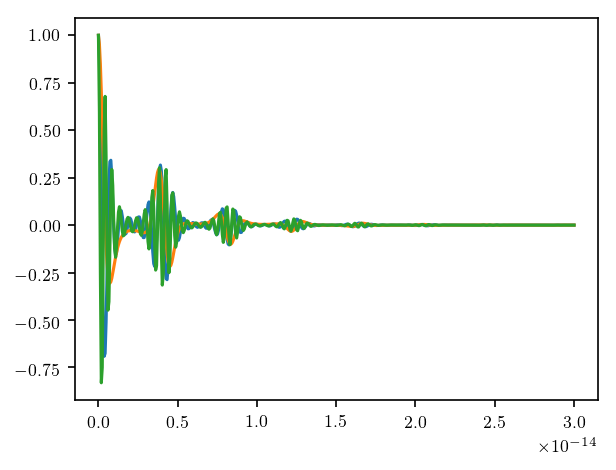

In [17]:
ts, integrands = test_lineshape_integrand
for integ in integrands:
    plt.plot(ts, integ)

Text(0, 0.5, 'Emission Lineshape [a.u.]')

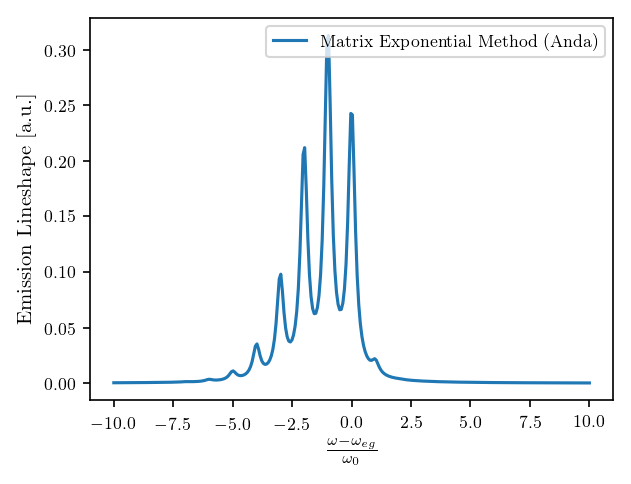

In [18]:
test_hbar_omegas = np.linspace(-10, 10, 300)

test_lineshape = flu_lineshape(
    omega=(test_hbar_omegas+1.28)/hbar, 
    gamma=.18/hbar, 
    H_e=test_He,
    rho_ex=test_rho,
    A=test_A,
    t_max=30,
    t_points=500,
    )

plt.plot(test_hbar_omegas, test_lineshape, label='Matrix Exponential Method (Anda)')
plt.xlabel(r'$\frac{\omega - \omega_{eg}}{\omega_0}$', fontsize=10)
plt.legend()
plt.ylabel(r'Emission Lineshape [a.u.]', fontsize=10)

Plot B2 to compare to Mukamel model 

In [20]:
k2 = big_b_tilde(
    ts, 
    order_n=2, 
    H_e=test_He, 
    rho_ex=test_rho, 
    A=test_A,
#     e_At=None,
#     return_e_At_in_dict=True
    )

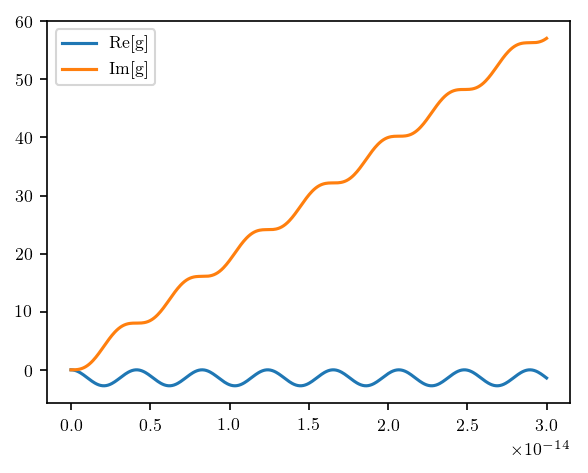

In [21]:
plt.plot(ts, np.real(k2), label='Re[g]')
plt.plot(ts, np.imag(k2), label='Im[g]')
plt.legend()

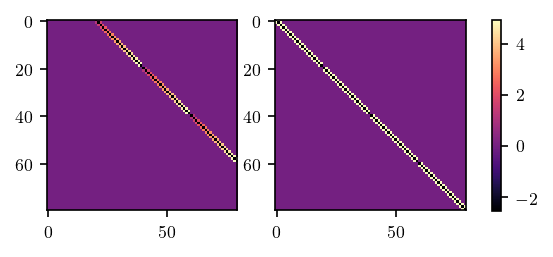

In [22]:
fig, axs = plt.subplots(1, 2)

im =axs[0].imshow(np.real(test_A), origin='upper')
clim=im.properties()['clim']
axs[1].imshow(np.imag(test_A), clim=clim, origin='upper')

fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.5)

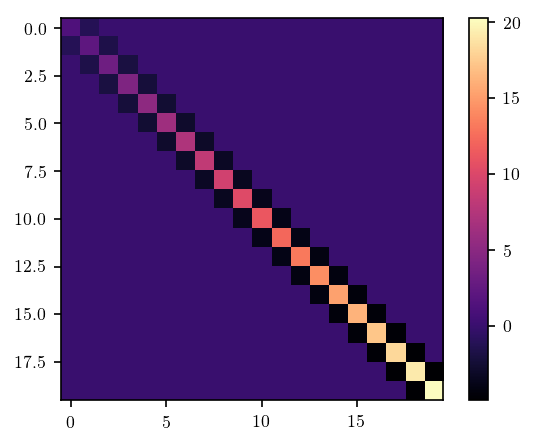

In [23]:
plt.imshow(test_He, origin='upper')
plt.colorbar()

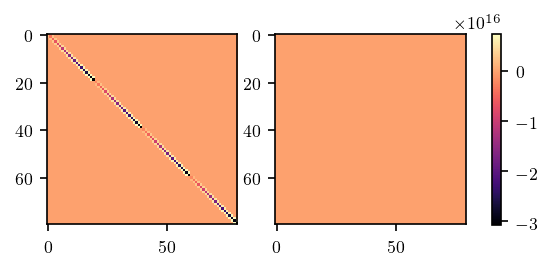

In [24]:
fig, axs = plt.subplots(1, 2)

im =axs[0].imshow(np.imag(test_A), origin='upper')
clim=im.properties()['clim']
axs[1].imshow(np.real(test_A), clim=clim, origin='upper')

fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.5)

In [25]:
test_tay_expm = taylor_expm(test_A, 200)
test_lin_expm = lin.expm(test_A)
np.allclose(test_tay_expm, test_lin_expm)

/Users/chair/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


False

In [26]:
test_tay_expm = taylor_expm(test_A*1e-15, 100)
test_lin_expm = lin.expm(test_A*1e-15)
np.allclose(test_tay_expm, test_lin_expm)

False

In [27]:
test_tay_expm = taylor_expm(test_A*1e-15/hbar, 100)
test_lin_expm = lin.expm(test_A*1e-15/hbar)
np.allclose(test_tay_expm, test_lin_expm)

/Users/chair/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


False

So the exponential is computed correctly as long as A is order 1e-15

##### Check that A is symmetric about the antidiagonal

In [28]:
np.allclose(
    lin.expm(test_A*1e-15)[0:20, 40:60],
    lin.expm(test_A*1e-15)[0:20, 60:],
    )

True

In [29]:
test_tay_expm = taylor_expm(test_He, 60)
test_lin_expm = lin.expm(test_He)
np.allclose(test_tay_expm, test_lin_expm)

True

### Compute block of A directly 

\begin{equation}
\int_0^{t} \mathrm{d}t_1 \int_0^{t_1} \mathrm{d}t_2
e^{-i \mathbf{H_g}(t-t_1)}
\boldsymbol{\Delta}
e^{-i \mathbf{H_g}(t_1-t_2)}
\boldsymbol{\Delta}
e^{-i \mathbf{H_g}t_2}
\end{equation}

In [30]:
def k2_integrand(he, delta, t2, t1, t):
    ## reshape matricies to (t, t1, t2, nxn)
#     he = he[None, None, None, :]
    delta = delta[None, None, None, :]
#     t2 = t2[None, None, :, None, None]
#     t1 = t1[None, :, None, None, None]
#     t = t[:, None, None, None, None]
    
    ## Compute first matrix exponential
#     exp1_arg = - he * (t - t1)
    exp1 = np.zeros((len(t), len(t1), len(t2))+he.shape, dtype='complex')
    exp2 = np.zeros_like(exp1, dtype='complex')
    exp3 = np.zeros_like(exp1, dtype='complex')

    for i_t in range(t.shape[0]):
        for i_t1 in range(t1.shape[0]):
            for i_t2 in range(t2.shape[0]):
                if (t[i_t] - t1[i_t1]) < 0 or (t1[i_t1] - t2[i_t2]) < 0:
                    exp1[i_t, i_t1, i_t2, ...] = 0
                    exp2[i_t, i_t1, i_t2, ...] = 0
                    exp3[i_t, i_t1, i_t2, ...] = 0
                    continue
                else:
                    exp1[i_t, i_t1, i_t2, ...] = lin.expm(
                        - 1j*he * (t[i_t] - t1[i_t1]))
                    exp2[i_t, i_t1, i_t2, ...] = lin.expm(
                        - 1j*he * (t1[i_t1] - t2[i_t2]))
                    exp3[i_t, i_t1, i_t2, ...] = lin.expm(
                        - 1j*he * t2[i_t2])

    integrand = exp1@delta@exp2@delta@exp3
    
    return integrand
        

In [31]:
_ts = np.linspace(0, 2, 10)*1e-15

In [32]:
_integrand = k2_integrand(he=test_He, delta=test_D, t2=_ts, t1=_ts, t=_ts)

In [33]:
_integrand.shape

(10, 10, 10, 20, 20)

In [34]:
# integrand_diff_to_plot = (
#     _integrand[0, 0, 1, :, :]
#     -
#     _integrand[0, 0, 0, :, :]
#     )


# fig, axs = plt.subplots(1, 2)

# im =axs[0].imshow(np.real(integrand_diff_to_plot), origin='upper')
# clim=im.properties()['clim']
# axs[1].imshow(np.imag(integrand_diff_to_plot), clim=clim, origin='upper')

# fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.5)

Need to set integrand to zero if not t > t1 > t2

In [35]:
t2_integral = inte.trapz(_integrand, _ts, axis=-3)
t1_integral = inte.trapz(t2_integral, _ts, axis=-3)

In [36]:
t1_integral.shape

(10, 20, 20)

In [37]:
_k2 = 1/hbar**2 * np.trace(
    loopy_expm(1j*test_He[None, :]*_ts[:,None, None])
    @
    t1_integral
    @
    test_rho[None, :],
    axis1=-1,
    axis2=-2,
    )

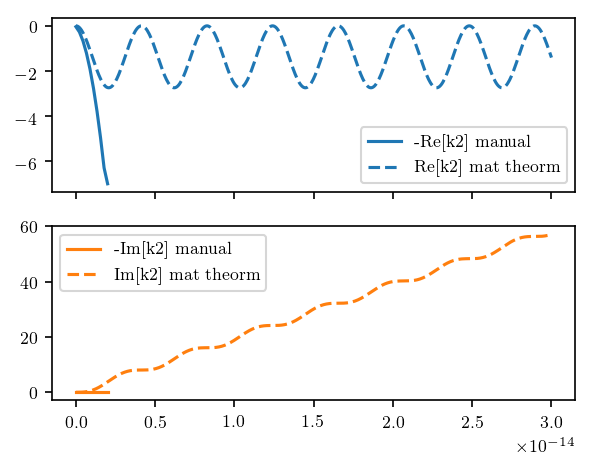

In [38]:
fig, axs = plt.subplots(2, 1, sharex='all')

axs[0].plot(_ts, -np.real(_k2), c='C0', label='-Re[k2] manual')
axs[1].plot(_ts, -np.imag(_k2), c='C1', label='-Im[k2] manual')

axs[0].plot(ts, np.real(k2), ls ='--', c='C0', label='Re[k2] mat theorm')
axs[1].plot(ts, np.imag(k2), ls ='--', c='C1', label='Im[k2] mat theorm')

axs[0].legend()
axs[1].legend()

Now that I have a vbersion of the manual integral that matches the mat. theorm implementation, I can start trying to fix the uits and see what happens




In [39]:
def k2_integrand_uni(he, delta, t2, t1, t):
    ## reshape matricies to (t, t1, t2, nxn)
#     he = he[None, None, None, :]
    delta = delta[None, None, None, :]
#     t2 = t2[None, None, :, None, None]
#     t1 = t1[None, :, None, None, None]
#     t = t[:, None, None, None, None]
    
    ## Compute first matrix exponential
#     exp1_arg = - he * (t - t1)
    exp1 = np.zeros((len(t), len(t1), len(t2))+he.shape, dtype='complex')
    exp2 = np.zeros_like(exp1, dtype='complex')
    exp3 = np.zeros_like(exp1, dtype='complex')

    for i_t in range(t.shape[0]):
        for i_t1 in range(t1.shape[0]):
            for i_t2 in range(t2.shape[0]):
                if (t[i_t] - t1[i_t1]) < 0 or (t1[i_t1] - t2[i_t2]) < 0:
                    exp1[i_t, i_t1, i_t2, ...] = 0
                    exp2[i_t, i_t1, i_t2, ...] = 0
                    exp3[i_t, i_t1, i_t2, ...] = 0
                    continue
                else:
                    exp1[i_t, i_t1, i_t2, ...] = lin.expm(
                        - 1j*he/hbar * (t[i_t] - t1[i_t1]))
                    exp2[i_t, i_t1, i_t2, ...] = lin.expm(
                        - 1j*he/hbar * (t1[i_t1] - t2[i_t2]))
                    exp3[i_t, i_t1, i_t2, ...] = lin.expm(
                        - 1j*he/hbar * t2[i_t2])

    integrand = exp1@delta@exp2@delta@exp3
    
    return integrand
        

In [40]:
_ts = np.linspace(0, 2, 50)*1e-15

In [41]:
_integrand_uni = k2_integrand_uni(he=test_He, delta=test_D, t2=_ts, t1=_ts, t=_ts)

Need to set integrand to zero if not t > t1 > t2

In [42]:
t2_integral_uni = inte.trapz(_integrand_uni, _ts, axis=-3)
t1_integral_uni = inte.trapz(t2_integral_uni, _ts, axis=-3)

In [43]:
_k2_uni = 1/hbar**2 * np.trace(
    loopy_expm(1j*test_He[None, :]/hbar*_ts[:,None, None])
    @
    t1_integral_uni
    @
    test_rho[None, :],
    axis1=-1,
    axis2=-2,
    )

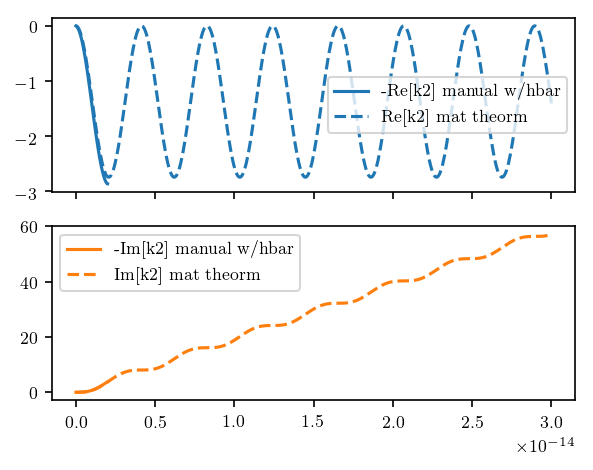

In [44]:
fig, axs = plt.subplots(2, 1, sharex='all')

axs[0].plot(_ts, -np.real(_k2_uni), c='C0', label='-Re[k2] manual w/hbar')
axs[1].plot(_ts, -np.imag(_k2_uni), c='C1', label='-Im[k2] manual w/hbar')

axs[0].plot(ts, np.real(k2), ls ='--', c='C0', label='Re[k2] mat theorm')
axs[1].plot(ts, np.imag(k2), ls ='--', c='C1', label='Im[k2] mat theorm')

axs[0].legend()
axs[1].legend()

In [45]:
# tt = np.array([0.00000000e+00, 5.05050505e-17, 1.01010101e-16, 1.51515152e-16])
tt = np.array([1.51515152e-16])

# tt = 1.51515152e-16

b2 =big_b_tilde(
    t=tt,
    order_n=2, 
    H_e=test_He, 
    rho_ex=test_rho, 
    A=test_A, 
    e_At=None, 
#     return_e_At_in_dict=True,
    )

b3 =big_b_tilde(
    t=tt,
    order_n=3, 
    H_e=test_He, 
    rho_ex=test_rho, 
    A=test_A, 
    e_At=None, 
#     return_e_At_in_dict=True,
    )

print(f"exp_arg = {b3 + b2}" )

np.real(np.exp(
    (-1j*0/hbar - .18/hbar)*tt
    +
    b3 + b2) )

exp_arg = [-0.03626112+0.00259525j]


array([0.92524283])

In [46]:
test_t = np.array([1.51515152e-16])
_test_H_e = test_He[None, ...]
_test_t = test_t[:, None, None]
_test_A = test_A[None, ...]
test_eigy_expm_eAT = eigy_expm(_test_A*_test_t)
test_eigy_expm_eAT[0].shape

(80, 80)

In [47]:
exp_func = lin.expm
test_e_At = lin.expm(test_A*test_t[0])
test_e_At.shape

(80, 80)

In [48]:
np.allclose(test_eigy_expm_eAT[0], test_e_At)

False

In [49]:
np.allclose((_test_A*test_t)[0], test_A*test_t[0])

True

In [50]:
(test_He[None, ...]*tt[:, None, None]).shape

(1, 20, 20)

In [51]:
eigy_expm((test_He[None, ...]*tt[:, None, None])).shape

(1, 20, 20)

In [52]:
np.all(eigy_expm(test_He) == eigy_expm(test_He[None, ...]))

True

In [53]:
np.allclose(lin.expm(test_He), eigy_expm(test_He[None, ...]))

True

In [54]:
np.allclose(lin.expm(test_He*test_t[0]), eigy_expm(test_He[None, ...]*_test_t))

True

In [55]:
np.allclose(lin.expm(test_A*test_t[0]), eigy_expm(test_A[None, ...]*_test_t))

False

In [56]:
np.allclose(lin.expm(test_A), eigy_expm(test_A[None, ...])[0])

False

In [57]:
lin.expm(test_A).shape

(80, 80)

In [58]:
eigy_expm(test_A[None, ...]).shape

(1, 80, 80)

In [59]:
test_A

array([[0.-1.94466235e+15j, 0.+1.71885492e+15j, 0.-0.00000000e+00j, ...,
        0.+0.00000000e+00j, 0.+0.00000000e+00j, 0.+0.00000000e+00j],
       [0.+1.71885492e+15j, 0.-3.46392981e+15j, 0.+2.43082794e+15j, ...,
        0.+0.00000000e+00j, 0.+0.00000000e+00j, 0.+0.00000000e+00j],
       [0.-0.00000000e+00j, 0.+2.43082794e+15j, 0.-4.98319727e+15j, ...,
        0.+0.00000000e+00j, 0.+0.00000000e+00j, 0.+0.00000000e+00j],
       ...,
       [0.+0.00000000e+00j, 0.+0.00000000e+00j, 0.+0.00000000e+00j, ...,
        0.-2.77722092e+16j, 0.+7.29248381e+15j, 0.-0.00000000e+00j],
       [0.+0.00000000e+00j, 0.+0.00000000e+00j, 0.+0.00000000e+00j, ...,
        0.+7.29248381e+15j, 0.-2.92914766e+16j, 0.+7.49231489e+15j],
       [0.+0.00000000e+00j, 0.+0.00000000e+00j, 0.+0.00000000e+00j, ...,
        0.-0.00000000e+00j, 0.+7.49231489e+15j, 0.-3.08107441e+16j]])

In [60]:
vals, vecs = np.linalg.eig(test_A)
np.allclose(vecs @ np.diag(vals) @ np.linalg.inv(vecs), test_A)

False

In [61]:
vals, vecs = np.linalg.eig(test_He)
np.allclose(vecs @ np.diag(vals) @ np.linalg.inv(vecs), test_He)

True

In [62]:
vals, vecs = np.linalg.eig(test_A)
np.allclose(np.linalg.inv(vecs)@ np.diag(vals) @ vecs , test_A)

False

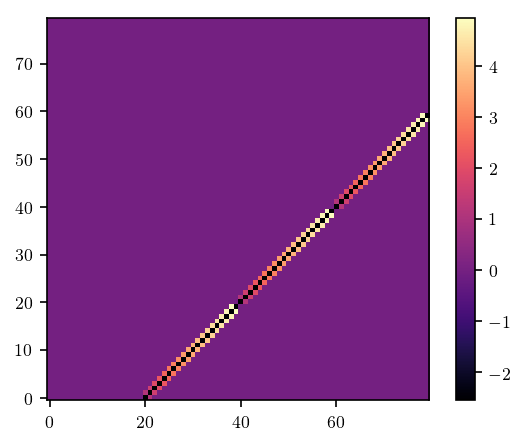

In [63]:
plt.imshow(np.real(test_A))
plt.colorbar()

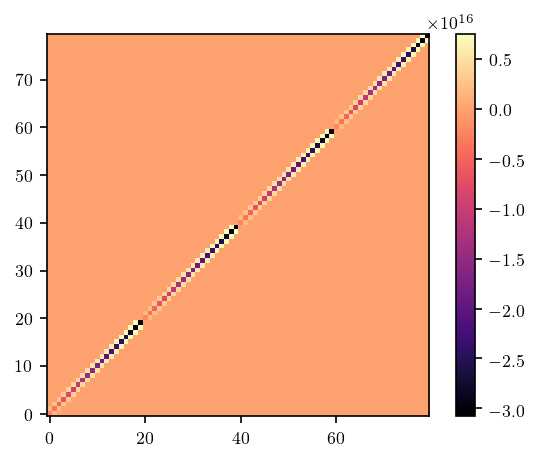

In [64]:
plt.imshow(np.imag(test_A))
plt.colorbar()

# Trying to reproduce Anda's first example

The Morse potential expanded to 12th order yields the polynomial, 
\begin{multline}
    0.500141 x^{2} - 0.0456629 x^{3} + 0.00243193 x^{4} - 0.000095158 x^{5} \\
    + 2.99251*10^{-6} x^{6} - 7.93207*10^{-8} x^{7} + 1.82486*10^{-9} x^{8} \\
    - 3.71702*10^{-11} x^{9} + 6.80059*10^{-13} x^{10} - 1.13*10^{-14} x^{11} \\
    + 1.72033*10^{-16} x^{12}
\end{multline}

In [617]:
mor_lam_g = [
    0,
    0,
    0.500141 - .5, ## to account for H_0 
    - 0.0456629,
    0.00243193,
    - 0.000095158,
    2.99251*1e-6,
    - 7.93207*1e-8,
    + 1.82486*1e-9,
    - 3.71702*1e-11,
    6.80059*1e-13,
    - 1.13*1e-14,
    + 1.72033*1e-16,
    ]

basis_size = 20
hbarw0_mor = 1

mor_lam_e = displaced_lambdas(mor_lam_g, 1.6)
Hg_mor = ham_g(basis_size, mor_lam_g)*hbarw0_mor
He_mor = ham_g(basis_size, mor_lam_e)*hbarw0_mor

T_mor = .3*hbarw0_mor/k
D_mor = gap_fluc_op(basis_size, mor_lam_g, mor_lam_e, T_mor)*hbarw0_mor
A_mor = a_matrix(He_mor, D_mor, order=7)
rho_mor = rho_e(He_mor, T_mor)

# big_b_tilde(t=100*1e-15, order_n=6, H_e=Hg_mor, A=A_mor, rho_ex=rho_mor)

hbar_omegas_mor = np.linspace(0, 10, 4)

# lineshape_mor = flu_lineshape(
#     omega=hbar_omegas_mor/hbar, 
#     gamma=.18/hbar, 
#     H_e=He_mor,
#     rho_ex=rho_mor,
#     A=A_mor,
#     t_max=.8,
#     t_points=1000,
# #     return_integrand=True
#     )
# lineshape_mor_integrand = flu_lineshape(
#     omega=hbar_omegas_mor/hbar, 
#     gamma=.18/hbar, 
#     H_e=He_mor,
#     rho_ex=rho_mor,
#     A=A_mor,
#     t_max=20,
#     t_points=600,
#     return_integrand=True
#     )

In [618]:
# ts, integrands = lineshape_mor_integrand
# for integ in integrands:
#     plt.plot(ts, integ)

In [619]:
hbar_omegas_mor = np.linspace(-5, 10, 300)
lineshape_mor = flu_lineshape(
    omega=hbar_omegas_mor/hbar, 
    gamma=.18/hbar, 
    H_e=He_mor,
    rho_ex=rho_mor,
    A=A_mor,
    t_max=20,
    t_points=600,
#     return_integrand=True
    )

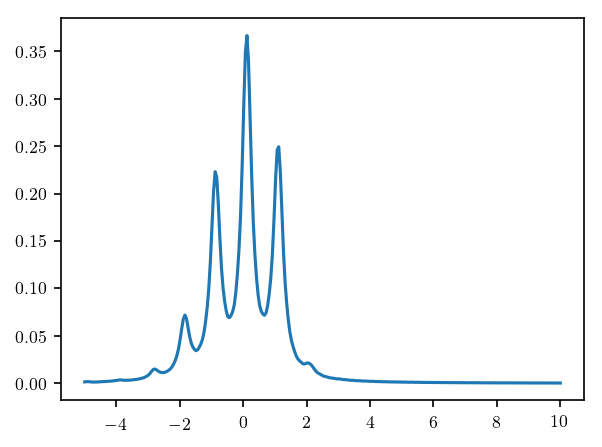

In [620]:
plt.plot(hbar_omegas_mor, lineshape_mor)

In [ ]:
int